In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

# Linear regression on the Ozone dataset - Regression trees, bagging and boosting 

In this notebook we are going to introduce *regression trees*, and explore the techniques of bagging (aka Boostrap Aggregation) and of gradient boosting

## The Ozone dataset

Let's take a look at a particular real-life data problem: the prediction of ozone concentration as a factor of other weather-based features. As with all data problems, it behooves us to take a look at all of the information that we have about the dataset.


**Description**

These data record the level of atmospheric ozone concentration from
eight daily meteorological measurements made in the Los Angeles basin
in 1976.  Although measurements were made every day that year, some
observations were missing; here we have the 330 complete cases.  The
data were given to us by Leo Breiman; he was a consultant on a project
from which these data are taken.  The response, referred to as ozone,
is actually the log of the daily maximum of the hourly-average ozone
concentrations in Upland, California.

Source: https://web.stanford.edu/~hastie/ElemStatLearn/datasets/LAozone.data

Detailed variable names:

- ozone : Upland Maximum Ozone
- vh : Vandenberg 500 mb Height
- wind : Wind Speed (mph)
- humidity : Humidity (%)
- temp : Sandburg AFB Temperature
- ibh : Inversion Base Height
- dpg : Daggot Pressure Gradient
- ibt : Inversion Base Temperature
- vis : Visibility (miles)
- doy : Day of the Year

Now let's take a look at what this dataset looks like. We have imported the datased into a pandas dataframe. See e.g. http://pythonhow.com/accessing-dataframe-columns-rows-and-cells/ for a short tutorial on dataframes.

In [2]:
data = pd.read_csv("LAozone.csv")
print(f"data: {data.shape[0]} rows and {data.shape[1]} columns")
data.head()

data: 330 rows and 10 columns


,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7


Alright, we're ready to get started ! Our dataset contains

$\bullet$ $N=330$ data points $x_i$, each containing $P=9$ meteorological features 

$\bullet$ one target $y_i$, the Ozone concentration

Now, before we touch anything, we need to follow best practices. When faced with a new dataset, we need to set up some kind of objective comparison. To do this, we need to split our dataset into three parts: **Training** (and within that, **Validation**), and **Testing** sets. 

The best practice here is to take the test data and lock it away somewhere. It is always tempting to tune your algorithms to give the best test performance. However, even if the regression isn't explicitly *trained* on the test data, as practitioners, we could be continually making changes in an effort to get our numbers up.

Instead, we should deep-freeze the test data, and then tune as much as we can via **cross-validation (CV)** on our training data.

In [3]:
from sklearn.model_selection import train_test_split, KFold

# Convert from DataFrame to array
y = data['ozone'].values
X = data.iloc[:,1:10].astype(float).values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

print("Training samples: ", len(y_train))
print("Testing samples: ", len(y_test))

Training samples:  247
Testing samples:  83


Now, before we start attempting to fit models, lets take a bit of care and apply some pre-processing to our dataset. The de-facto pre-processing is *centering and normalization*. Specifically, many flavors of estimators (OLS, RR, etc.) can be thrown of by large differences in of scale and variations between the features. We can easily account for this in our estimators by simply normalizing the feature columns and removing averages. Scikit-Learn has some features for this.

In [4]:
from sklearn import preprocessing 

# Center and scale features and observations
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
ymean = np.mean(y_train)
y_train = y_train - ymean
y_test = y_test - ymean

Now it is time for us to choose our estimator. What should we choose? 

We will begin by familiar estimators, such as **OLS**, **Ridge**, and **Lasso**.

Next, we will introduce **Regression Trees**, and on them we will apply the methods of **Bagging** and **Gradient Boosting**.

## Attempt 1: Ordinary Least Square

We begin by the OLS estimate, $\hat w = (X^T X)^{-1} X^T y$. We will plot the estimate of $w$, and compute the Residual Sum of Squares (RSS) on the training and test datasets.

In [5]:
# Calculate the OLS estimate
reg_ols = np.linalg.solve(np.dot(X_train.T, X_train), np.dot(X_train.T, y_train))

# Prediction for the train and test datasets
yp = np.dot(X_train, reg_ols)
yp_test = np.dot(X_test, reg_ols)

Normalized RSS (train): 18.28
Normalized RSS (test): 22.53


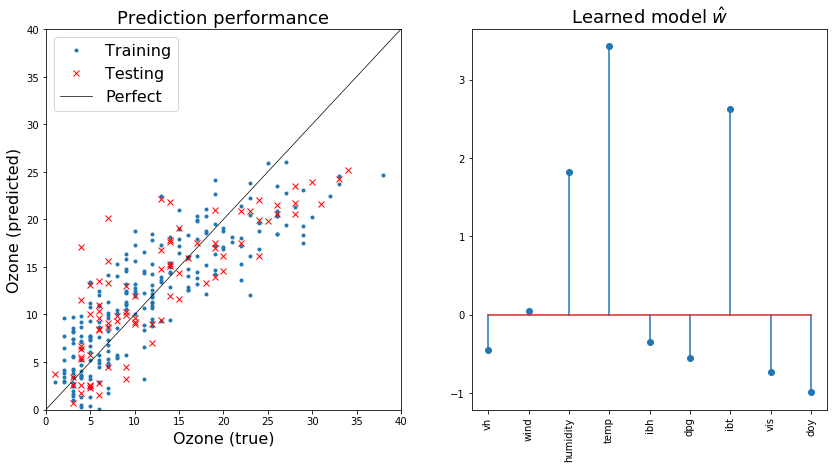

In [6]:
# Visualize
plt.figure(figsize=(14,7))

plt.subplot(121)
plt.plot(y_train + ymean,yp + ymean, '.', label='Training')
plt.plot(y_test + ymean, yp_test + ymean, '.r', label='Testing', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction performance', fontsize=18)

# Plot the learned model
plt.subplot(122)
plt.stem(reg_ols)
plt.title(r'Learned model $\hat{w}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

# Print Residual Sum of Squares (RSS)
rss_train = np.mean((y_train - yp) ** 2)
rss_test = np.mean((y_test - yp_test) ** 2)
print("Normalized RSS (train): %0.2f" % rss_train)
print("Normalized RSS (test): %0.2f" % rss_test)

## Attempt 2: Ridge Regression

Next we try Ridge Regression. Now, we need to perform some kind of Cross Validation (CV) to find the best regularization parameter for our model. 

In [7]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV

# Define a scoring metric
# To compare fits, we look at the prediction error via the RSS.
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean((y - yp) ** 2)

# Define CV splitting
# We can create an iterator which performs a set of randomized 
# splits on the dataset into "train" and "validation". We have
# a natural tradeoff between the test set size and the number of 
# splits we should perform
cv = ShuffleSplit(n_splits=20, test_size=0.1, random_state=0)

# Define parameters to search
param_grid = [
    {'alpha': np.logspace(-4, 3, 50)}
]

# Run the CV
cv_ridge = GridSearchCV(linear_model.Ridge(alpha=0.01), param_grid, scoring=neg_rss, cv=cv)
cv_ridge.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-04,   1.38950e-04,   1.93070e-04,   2.68270e-04,
         3.72759e-04,   5.17947e-04,   7.19686e-04,   1.00000e-03,
         1.38950e-03,   1.93070e-03,   2.68270e-03,   3.72759e-03,
         5.17947e-03,   7.19686e-03,   1.00000e-02,   1.38950e-02,
         1...   1.93070e+02,   2.68270e+02,   3.72759e+02,   5.17947e+02,
         7.19686e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function neg_rss at 0x1a20f63d08>, verbose=0)

Great ! Now lets take a look at the performance of our estimator. We chart over the $\alpha$ parameter that we perform CV against.

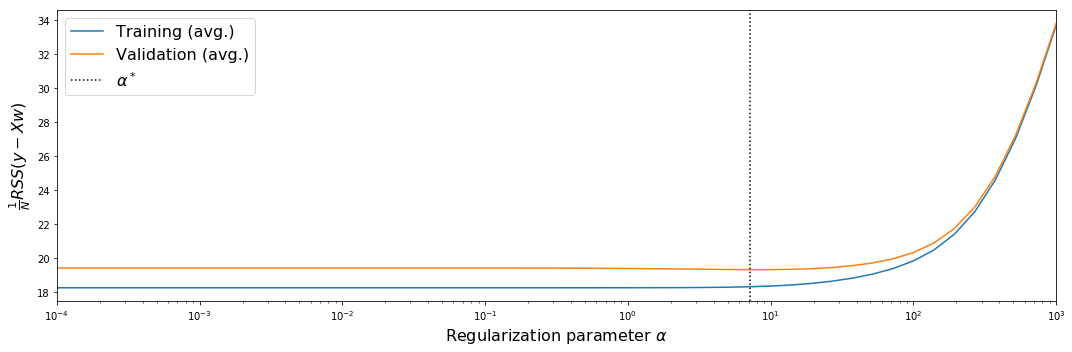

In [8]:
# Record CV optimizing hyper-params
opt_alpha = cv_ridge.best_params_['alpha']

# Visualize
tested_alpha = cv_ridge.cv_results_["param_alpha"].compressed()
train_scores = -cv_ridge.cv_results_["mean_train_score"]   # Reverse sign
test_scores = -cv_ridge.cv_results_["mean_test_score"]     # Reverse sign

plt.figure(figsize=(15,5))
plt.plot(tested_alpha, train_scores, '-', label='Training (avg.)')
plt.plot(tested_alpha, test_scores, '-', label='Validation (avg.)')
plt.xlabel(r'Regularization parameter $\alpha$', fontsize=16)
plt.ylabel(r'$\frac{1}{N} RSS(y - X w)$', fontsize=16)
plt.axvline(opt_alpha, label=r'$\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([1e-4, 1e3])
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

And now, finally, we are ready to take our test data out of deep-freeze. How did we do?

Normalized RSS (Train): 18.32
Normalized RSS  (Test): 22.60


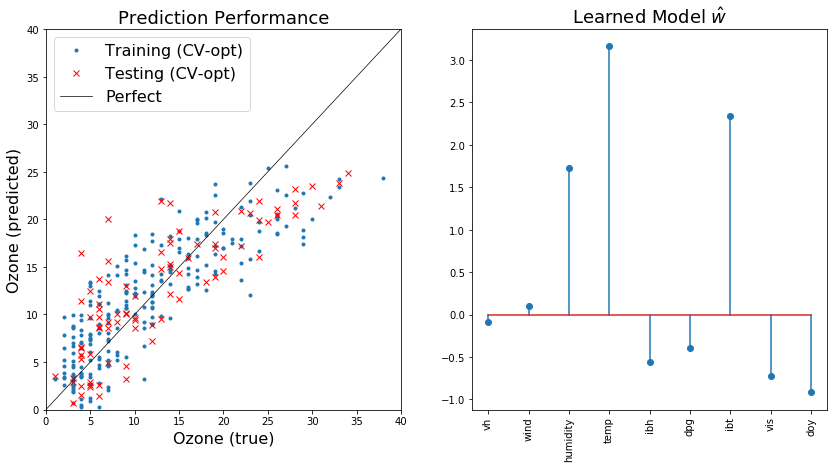

In [9]:
# Get training predictions
best_ridge = linear_model.Ridge(alpha=opt_alpha)
best_ridge.fit(X_train, y_train)
yp = best_ridge.predict(X_train)
yp_test = best_ridge.predict(X_test)

# Visualize
plt.figure(figsize=(14,7))

plt.subplot(121)
plt.plot(y_train + ymean, yp + ymean, '.', label='Training (CV-opt)')
plt.plot(y_test + ymean, yp_test + ymean, '.r', label='Testing (CV-opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

# Plot the learned model
plt.subplot(122)
plt.stem(best_ridge.coef_)
plt.title(r'Learned Model $\hat{w}$', fontsize=18)
plt.xticks(range(9), data.keys()[1:10], rotation='vertical')

# Print RSS
print("Normalized RSS (Train): %0.2f" % -neg_rss(best_ridge, X_train, y_train))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(best_ridge, X_test, y_test))

The Ridge regression, with optimal $\alpha$, does not perform better than the OLS in this problem. The learned model is very similar.

## Attempt 3: Lasso

Next, we try Lasso. Also in this case we need to perform a CV to determine the best regularization parameter. We repeat the same steps as in the Ridge regression case.

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV

# Define parameters to search
param_grid = [
    {'alpha': np.logspace(-4, 3, 50)}
]

# Run the CV
cv_lasso = GridSearchCV(linear_model.Lasso(alpha=1.0), param_grid, scoring=neg_rss, cv=cv)
cv_lasso.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-04,   1.38950e-04,   1.93070e-04,   2.68270e-04,
         3.72759e-04,   5.17947e-04,   7.19686e-04,   1.00000e-03,
         1.38950e-03,   1.93070e-03,   2.68270e-03,   3.72759e-03,
         5.17947e-03,   7.19686e-03,   1.00000e-02,   1.38950e-02,
         1...   1.93070e+02,   2.68270e+02,   3.72759e+02,   5.17947e+02,
         7.19686e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function neg_rss at 0x1a20f63d08>, verbose=0)

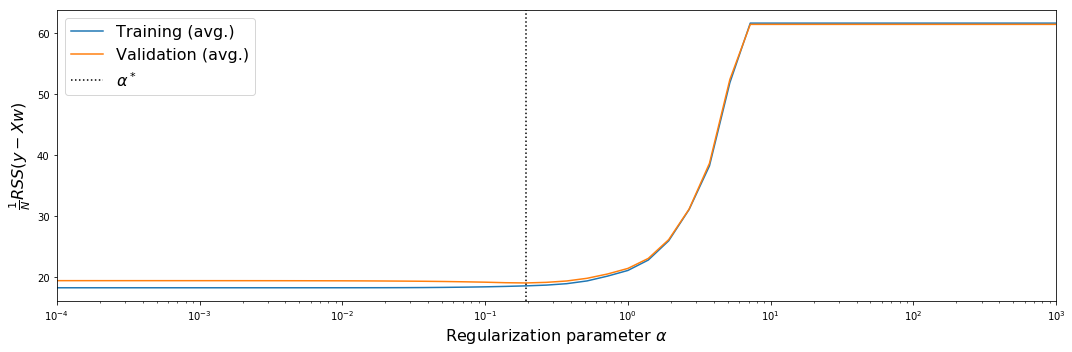

In [11]:
# Record CV optimizing hyper-params
opt_alpha = cv_lasso.best_params_['alpha']

# Visualize
tested_alpha = cv_lasso.cv_results_["param_alpha"].compressed()
train_scores = -cv_lasso.cv_results_["mean_train_score"]   # Reverse sign
test_scores = -cv_lasso.cv_results_["mean_test_score"]     # Reverse sign

plt.figure(figsize=(15,5))
plt.plot(tested_alpha, train_scores, '-', label='Training (avg.)')
plt.plot(tested_alpha, test_scores, '-', label='Validation (avg.)')
plt.xlabel(r'Regularization parameter $\alpha$', fontsize=16)
plt.ylabel(r'$\frac{1}{N} RSS(y - X w)$', fontsize=16)
plt.axvline(opt_alpha, label=r'$\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([1e-4, 1e3])
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

In the Lasso case we see better that there is an optimal $\alpha$. At small $\alpha$, we are slighly overfitting the training set: the training error is smaller than the validation error. At large $\alpha$, we have too few non-zero parameters and we have bad performance both on training and validation set.

Normalized RSS (Train): 18.32
Normalized RSS  (Test): 22.60


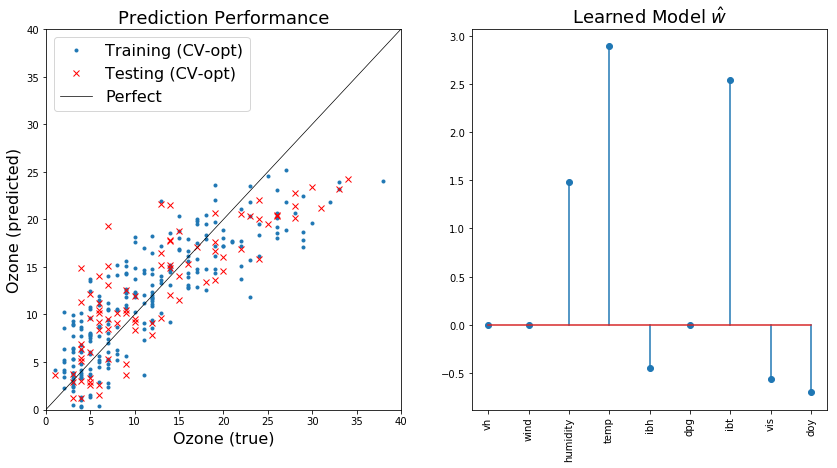

In [12]:
# Get training predictions
best_lasso = linear_model.Lasso(alpha=opt_alpha)
best_lasso.fit(X_train, y_train)
yp = best_lasso.predict(X_train)
yp_test = best_lasso.predict(X_test)

# Visualize
plt.figure(figsize=(14,7))

plt.subplot(121)
plt.plot(y_train + ymean, yp + ymean, '.', label='Training (CV-opt)')
plt.plot(y_test + ymean, yp_test + ymean, '.r', label='Testing (CV-opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

# Plot the learned model
plt.subplot(122)
plt.stem(best_lasso.coef_)
plt.title(r'Learned Model $\hat{w}$', fontsize=18)
plt.xticks(range(9), data.keys()[1:10], rotation='vertical')

# Print RSS
print("Normalized RSS (Train): %0.2f" % -neg_rss(best_ridge, X_train, y_train))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(best_ridge, X_test, y_test))

But in the end, once again we get no improvement over the OLS result!
We can compare the Ridge and Lasso results. We observe that Lasso has set to zero some coefficients that were small but non-zero in Ridge, while keeping the same accuracy. This is a useful result: we have learned that three features (vh, wind, dpg) are irrelevant to determine the Ozone concentration.

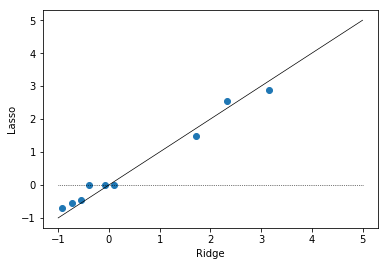

In [13]:
plt.plot(best_ridge.coef_,best_lasso.coef_,"o")
plt.plot([-1, 5], [-1, 5], '-k', linewidth=0.7)
plt.plot([-1, 5], [0, 0], '-k', linewidth=0.7, linestyle=':')
plt.xlabel("Ridge")
plt.ylabel("Lasso")

## Regression trees

Now, we introduce regression trees. Regression trees are perhaps the simplest non-linear regression model one can imagine. The tree is constructed recursively. At each step, the training set is split in two parts according to a binary question ("Is feature $x_\mu < q$?"). The feature and the threshold are chosen to minimize a Loss function, e.g. Mean Square Error (MSE) or Mean Absolute Error (MAE).

Once the tree is constructed, for a new sample $x_{new}$, one simply determines in which leave it falls, and then assign the value $y_{new}$ as the mean (for MSE) or the median (for MAE) of the traning samples in that leave.

Regression trees (e.g. as implemented in sklearn) have many free parameters: the maximum depth of the tree, the minimum number of samples that should be contained in each split, the minimum number of samples in the leaves, etc. We have thus to perform CV for at least some of these parameters.

See http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor for documentation, and references therein for more details on regression trees.


In [14]:
from sklearn.tree import DecisionTreeRegressor

regr_tree = DecisionTreeRegressor(max_depth=2)

param_grid = [
    {'criterion': ['mse', 'mae'],
     'max_depth': range(2, 10, 1),
     'min_samples_split': range(2, 20, 2),
     'min_samples_leaf' : range(2, 10, 1)
    } 
]

# Run the CV
cv_tree = GridSearchCV(regr_tree, param_grid, scoring=neg_rss, cv=cv)
cv_tree.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['mse', 'mae'], 'max_depth': range(2, 10), 'min_samples_split': range(2, 20, 2), 'min_samples_leaf': range(2, 10)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function neg_rss at 0x1a20f63d08>, verbose=0)

In [15]:
# Display results for best estimator
cv_tree.best_estimator_

DecisionTreeRegressor(criterion='mae', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Normalized RSS (train): 11.04
Normalized RSS (test): 24.84


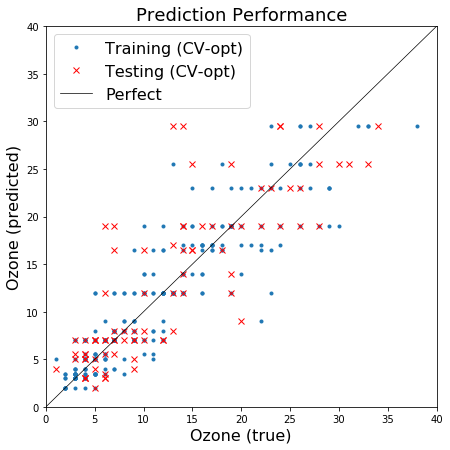

In [16]:
# Get training and testing predictions
cvopt_tree = cv_tree.best_estimator_
cvopt_tree.fit(X_train,y_train)
yp = cvopt_tree.predict(X_train)
yp_test = cvopt_tree.predict(X_test)

# Visualize
plt.figure(figsize=(7, 7))

# Plot prediction performance
plt.plot(y_train + ymean, yp + ymean, '.', label='Training (CV-opt)')
plt.plot(y_test + ymean, yp_test + ymean, '.r', label='Testing (CV-opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

# Print RSS
print("Normalized RSS (train): %0.2f" % -neg_rss(cvopt_tree, X_train, y_train))
print("Normalized RSS (test): %0.2f" % -neg_rss(cvopt_tree, X_test, y_test))

The regression tree is badly overfitting the training set. Its performances on the test set are worse than the ones of OLS, Ridge and Lasso. Note that regression tree can only output a discrete set of predictions for the $y$.

# Ensemble methods

The main idea behind ensemble methods is to improve multiple poor models from the data at hand, by combining them in a clever way. We are thus going to use the regression tree as the basic models, as we have seen that it provides quite poor results, and try to improve by considering ensembles of trees.

## Bagging

In bagging, we generate multiple models *in parallel*, each of them working with a different dataset, sampled at random from the original training set (i.e. we do *bootstrapping*). When sampling, we consider a different random subset of features $P'<P$ for each dataset, and we sample with replacement $N$ data points.

When we do that with decision trees, we get the **random forests** algorithm.
A good tutorial can be found here
https://gormanalysis.com/random-forest-from-top-to-bottom/

In principle, also in the random forests algorithm we have many free parameters (max split, max depth, etc.) but we will let the algorithm find the best trees, without performing cross validation in this case.

In [17]:
from sklearn import ensemble

# Create estimator object
reg_rf = ensemble.RandomForestRegressor(n_estimators=100)

# Fit estimator to training data
reg_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Normalized RSS (train): 2.44
Normalized RSS (test): 18.34


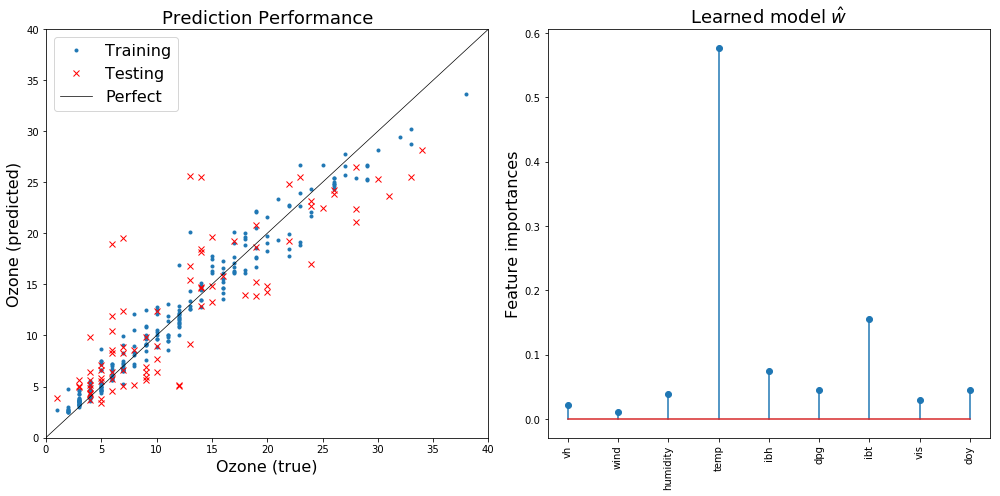

In [18]:
# Get training predictions
yp = reg_rf.predict(X_train)
yp_test = reg_rf.predict(X_test)

# Visualize
plt.figure(figsize=(14, 7))

# Plot prediction performance
plt.subplot(121)
plt.plot(y_train + ymean, yp + ymean, '.', label='Training')
plt.plot(y_test + ymean, yp_test + ymean, '.r', label='Testing', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

# Plot the learned model
plt.subplot(122)
plt.stem(reg_rf.feature_importances_)
plt.title(r'Learned model $\hat{w}$', fontsize=18)
plt.ylabel('Feature importances', fontsize=16)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

plt.tight_layout()

# Print RSS
print("Normalized RSS (train): %0.2f" % -neg_rss(reg_rf, X_train, y_train))
print("Normalized RSS (test): %0.2f" % -neg_rss(reg_rf, X_test, y_test))

We found that the random forests algorithm is strongly overfitting the training set (there are many free parameters), but at the same time it provides a big improvement in the performance on the test set. This is good!

The *feature importance* provided by the scikitlearn implementation is the average [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) over all trees in the ensemble. It is interesting to note that the features with larger scores also had large coefficients on the linear models we have fitted.

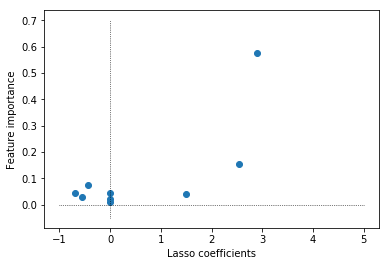

In [19]:
plt.plot(best_lasso.coef_,reg_rf.feature_importances_,"o")
plt.plot([-1, 5], [0, 0], '-k', linewidth=0.7, linestyle=':')
plt.plot([0, 0], [-0.05, 0.7], '-k', linewidth=0.7, linestyle=':')
plt.xlabel("Lasso coefficients")
plt.ylabel("Feature importance")

Let us try to get a better feeling of what's going on here. Each of the trained trees is actually accessible via the `estimators_` attribute. The total test error is computed as follows:

In [20]:
# Compute prediction on test set for each of the trees on the ensemble
yp_test_tree = [tree.predict(X_test) for tree in reg_rf.estimators_]

# Average over all predictions
yp_test = np.mean(yp_test_tree, axis=0)

# Compute mean-squared error between true and predicted labels
np.mean((y_test - yp_test) ** 2)

18.341753012048191

Note that the random forests algorithm is stochastic: if you run it multiple times you will get different results. Creating larger ensembles should lead in general to smaller variances. 

Can you compute the test error as a function of `n_estimators`? Tip: run it only once for a large value of `n_estimators` and repeat the procedure above for different numbers of trees.

## Boosting

In boosting, we successively generate models that, at each step, provide a better approximation to the function we are trying to determine.

With boosting methods, over-training becomes a very real possibility. In this case we need to make sure to use our CV in order to stop fine-tuning our boosting approach when we start to have a loss on the validation data.

We also have many possible different metrics to use in this case, not just the RSS. So, it is important to use our CV parameter grid to check many possible values. 
Note that there are two loss functions here: the one used to train the individual models, and the one used for the global boosting. Here we are going to try Least Squares (ls) and Least Absolute Deviation (lad) for the boosting, while for the training of individual trees we leave the default choice.

A good tutorial on boosting can be found here:
http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

In [21]:
from sklearn import ensemble

# Create estimator object
reg_gb = ensemble.GradientBoostingRegressor()

# Define the parameters to search
param_grid = [
    {'loss': ['ls','lad'],
     'learning_rate': np.logspace(-3, 0, 10),
     'n_estimators': range(50, 200, 50)} 
]

# Run the CV
cv_gb = GridSearchCV(reg_gb, param_grid, scoring=neg_rss, cv=cv)
cv_gb.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'loss': ['ls', 'lad'], 'learning_rate': array([ 0.001  ,  0.00215,  0.00464,  0.01   ,  0.02154,  0.04642,
        0.1    ,  0.21544,  0.46416,  1.     ]), 'n_estimators': range(50, 200, 50)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function neg_rss at 0x1a20f63d08>, verbose=0)

In [22]:
# Display results for best estimator
cv_gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.10000000000000001, loss='lad', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Normalized RSS (train): 7.54
Normalized RSS (test): 18.99


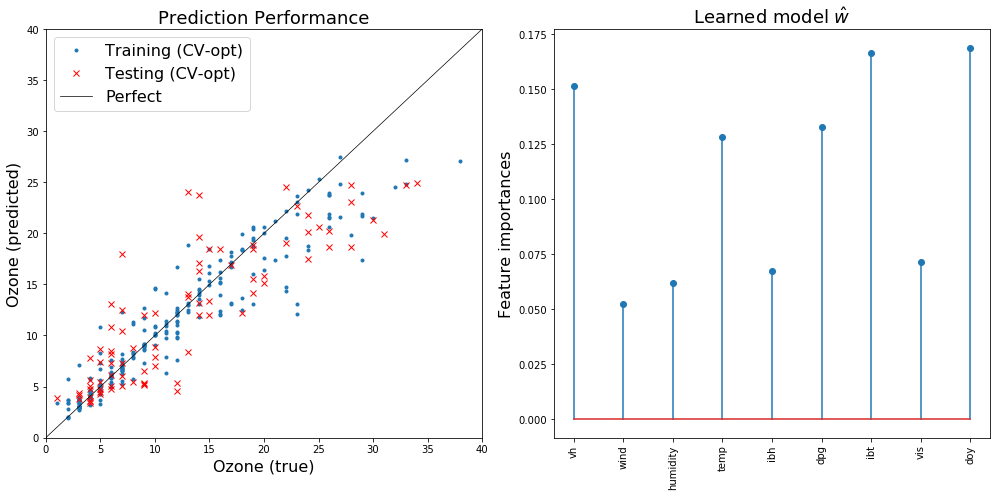

In [23]:
# Get training predictions
cvopt_gb = cv_gb.best_estimator_
cvopt_gb.fit(X_train,y_train)
yp = cvopt_gb.predict(X_train)
yp_test = cvopt_gb.predict(X_test)

# Visualize
plt.figure(figsize=(14, 7))

# Plot prediction performance
plt.subplot(121)
plt.plot(y_train + ymean, yp + ymean, '.', label='Training (CV-opt)')
plt.plot(y_test + ymean, yp_test + ymean, '.r', label='Testing (CV-opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

# Plot the learned model
plt.subplot(122)
plt.stem(cvopt_gb.feature_importances_)
plt.title(r'Learned model $\hat{w}$', fontsize=18)
plt.ylabel('Feature importances', fontsize=16)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

plt.tight_layout()

# Print RSS
print("Normalized RSS (train): %0.2f" % -neg_rss(cvopt_gb, X_train, y_train))
print("Normalized RSS (test): %0.2f" % -neg_rss(cvopt_gb, X_test, y_test))

### Comparison between random forests and gradient tree boosting

- In random forests, we train many models in parallel, whereas in gradient tree boosting, we do it sequentially
- Random forests have less hyperparameters to be adjusted
- Random forests, and bagging methods in general, are supposed to reduce the variance of the individual estimators, so tha the aggregate does not overfit as much. Therefore, it is better to use individual estimators with low bias and high variance (i.e. individual estimators should overfit!). In our example, we end up using deep trees (no limit on max_depth).
- Boosting methods on the other hand try to reduce the bias, or the training error, of the individual estimator. Therefore, it is better to use individual estimators with high bias and low variance (i.e. that have few free parameters and underfit). In our example, we used shallow trees (max_depth=3).

In the end, the performances of random forests and gradient boosting on the test set in our example were similar. But random forests had a smaller error on the training set.

See https://www.quora.com/What-are-the-differences-between-Random-Forest-and-Gradient-Tree-Boosting-algorithms for more details.

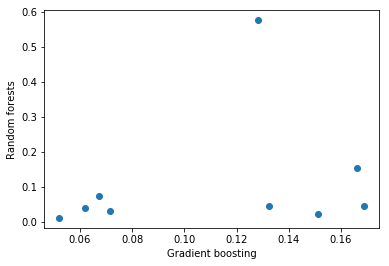

In [24]:
plt.plot(cvopt_gb.feature_importances_,reg_rf.feature_importances_,"o")
plt.xlabel("Gradient boosting")
plt.ylabel("Random forests")